In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/ERA - Phase I/Session 5/

/content/gdrive/My Drive/ERA - Phase I/Session 5


In [3]:
!ls 

model.py  README.md  S5.ipynb  utils.py


# Imports

In [4]:
from model import Net 

In [5]:
import utils as utils

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Dataset, Transforms

In [7]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


In [8]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [9]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 103547093.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99373005.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25370666.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 28690555.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
batch_size = 512
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

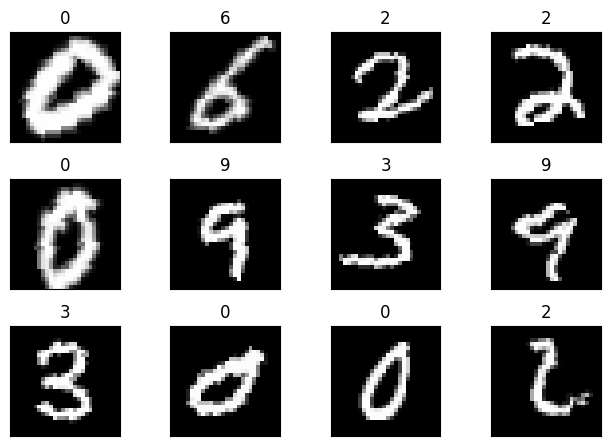

In [11]:
batch_data, batch_label = next(iter(train_loader)) 
utils.show_examples_dataset(batch_data, batch_label)

# Model

In [12]:
model = Net().to(device)
utils.show_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
None


# Training

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [14]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.6048 Batch_id=117 Accuracy=31.36: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 1.3661, Accuracy: 5186/10000 (51.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2144 Batch_id=117 Accuracy=84.94: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.1288, Accuracy: 9605/10000 (96.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0983 Batch_id=117 Accuracy=95.32: 100%|██████████| 118/118 [00:25<00:00,  4.67it/s]


Test set: Average loss: 0.0890, Accuracy: 9725/10000 (97.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1332 Batch_id=117 Accuracy=96.57: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0632, Accuracy: 9779/10000 (97.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0640 Batch_id=117 Accuracy=96.94: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s]


Test set: Average loss: 0.0611, Accuracy: 9799/10000 (97.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1002 Batch_id=117 Accuracy=97.39: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0514, Accuracy: 9831/10000 (98.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0496 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


Test set: Average loss: 0.0449, Accuracy: 9851/10000 (98.51%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0197 Batch_id=117 Accuracy=97.92: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0385, Accuracy: 9858/10000 (98.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0901 Batch_id=117 Accuracy=98.21: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0411, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0179 Batch_id=117 Accuracy=98.27: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0312, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0255 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:27<00:00,  4.37it/s]


Test set: Average loss: 0.0412, Accuracy: 9864/10000 (98.64%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0559 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0338, Accuracy: 9890/10000 (98.90%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1278 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0145 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s]


Test set: Average loss: 0.0350, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0614 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0286, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0048 Batch_id=117 Accuracy=98.91: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0150 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0314 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0601 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0194 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:24<00:00,  4.78it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.


# Results 

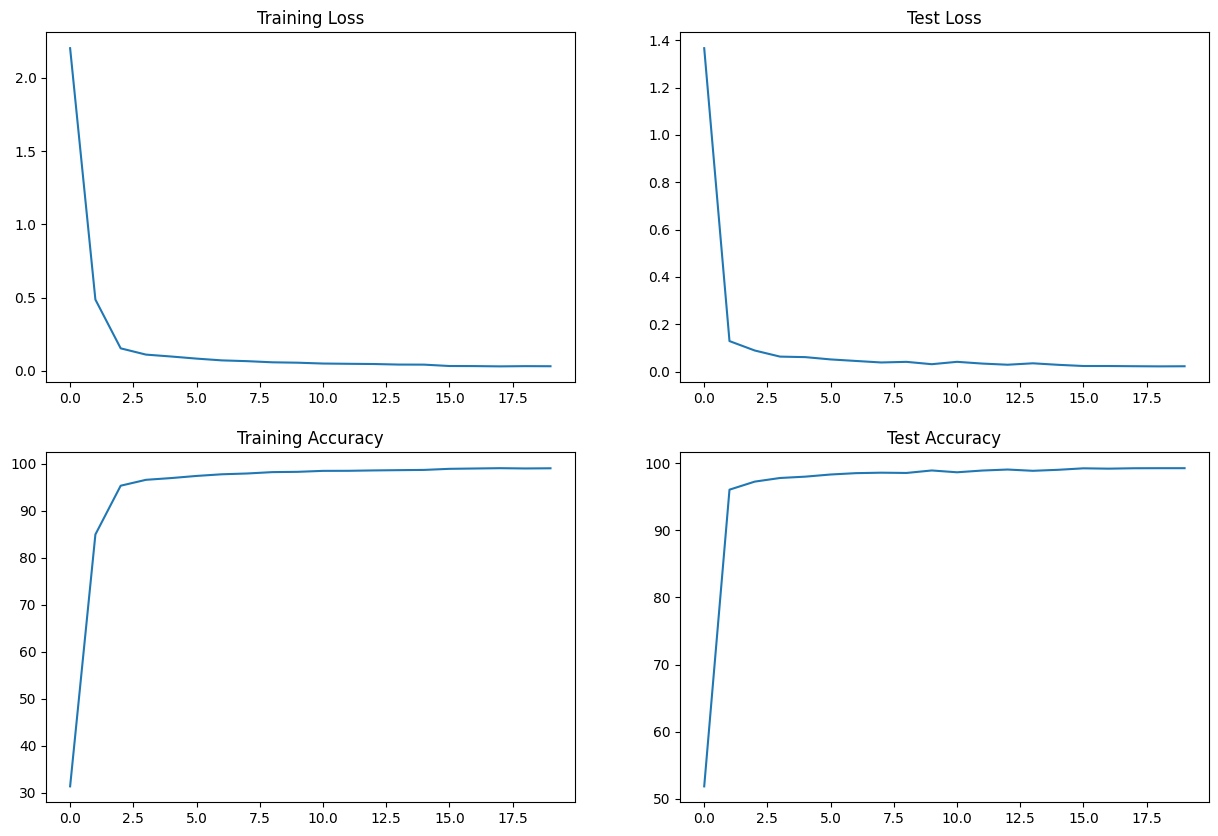

In [16]:
utils.plot_loss_accuracy([train_losses, test_losses, train_acc, test_acc])